In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from tensorflow_probability import distributions as tfd

from datetime import datetime

from utils import *

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [118]:
tf.reset_default_graph()


In [119]:
n_z = 20
batchsize = 32

# ENCODER
X = tf.placeholder(tf.float32, shape=[None, 784])
X_reshape = tf.reshape(X, [-1, 28,28,1])
def encoder(x):
    with tf.variable_scope("encoder"):
        h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[-1, 7*7*32])
        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev = tf.nn.softplus(dense(h2_flat, 7*7*32, n_z, "w_stddev"))
        posterior = tfd.MultivariateNormalDiag(w_mean, w_stddev)
    return posterior


# DECODER
def decoder(z):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        z_develop = dense(z, n_z, 7*7*32, scope='z_matrix')
        z_matrix = tf.nn.relu(tf.reshape(z_develop, [-1, 7, 7, 32]))
        h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
        h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
        h2 = tf.nn.sigmoid(h2)
        h2 = tf.reshape(h2, [-1, 784])
        dec = tfd.Bernoulli(probs=h2 + 1e-8)
        dec = tfd.Independent(
            distribution=dec,
            reinterpreted_batch_ndims=1,
            )
    return dec, h2

prior = tfd.MultivariateNormalDiag(tf.zeros(n_z), tf.ones(n_z))

posterior = encoder(X_reshape)
code = posterior.sample()

dec, generated_flat = decoder(code)
sampled_flat = dec.sample()
generated_images = tf.reshape(generated_flat, [-1, 28,28,1])
sampled_images = tf.reshape(sampled_flat, [-1, 28,28,1])


likelihood = dec.log_prob(X)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
cost = -elbo

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)



In [120]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [123]:
mb_size = batchsize
for it in range(9000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, c = sess.run((optimizer, cost), 
                                     feed_dict={X: X_mb})
    
    now = datetime.now()
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('gen_loss: {:.4}'. format(np.mean(c)))
#         print('lat_loss: {:.4}'.format(np.mean(lat_loss)))
        print(str(datetime.now()))
        print()

Iter: 0
gen_loss: 116.5
2019-05-16 16:58:23.269701

Iter: 100
gen_loss: 120.3
2019-05-16 16:58:26.246848

Iter: 200
gen_loss: 113.7
2019-05-16 16:58:29.112267

Iter: 300
gen_loss: 121.9
2019-05-16 16:58:31.732264

Iter: 400
gen_loss: 113.4
2019-05-16 16:58:35.153773

Iter: 500
gen_loss: 111.8
2019-05-16 16:58:37.835521

Iter: 600
gen_loss: 110.9
2019-05-16 16:58:41.377676

Iter: 700
gen_loss: 113.4
2019-05-16 16:58:44.268647

Iter: 800
gen_loss: 112.3
2019-05-16 16:58:46.901837

Iter: 900
gen_loss: 120.2
2019-05-16 16:58:49.812846

Iter: 1000
gen_loss: 120.6
2019-05-16 16:58:52.502144

Iter: 1100
gen_loss: 115.8
2019-05-16 16:58:55.113380

Iter: 1200
gen_loss: 112.8
2019-05-16 16:58:58.303356

Iter: 1300
gen_loss: 111.8
2019-05-16 16:59:00.982697

Iter: 1400
gen_loss: 98.52
2019-05-16 16:59:03.600945

Iter: 1500
gen_loss: 106.7
2019-05-16 16:59:06.246183

Iter: 1600
gen_loss: 119.0
2019-05-16 16:59:09.302070

Iter: 1700
gen_loss: 107.3
2019-05-16 16:59:11.997206

Iter: 1800
gen_loss: 1

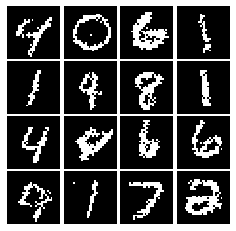

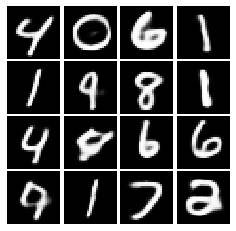

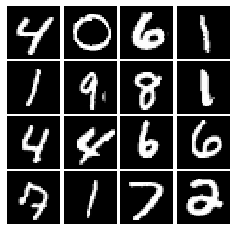

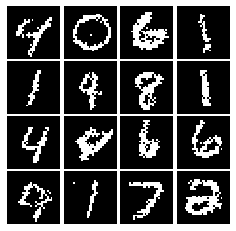

In [124]:
g, s, r, z = sess.run([generated_images, sampled_images, X_reshape, code], feed_dict={X: X_mb})
plot(g)
plot(r)
plot(s)